In [1]:
import torch
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 2070'

In [26]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

import matplotlib.pyplot as plt
import cv2
import numpy as np

from pprint import pprint
from pathlib import Path
from PIL import Image

PROJECT_ROOT = Path("..")


In [3]:
def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    


def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if True: #len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('on')
        plt.show()


def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0,0,1,0.4), thickness=1) 

    ax.imshow(img)

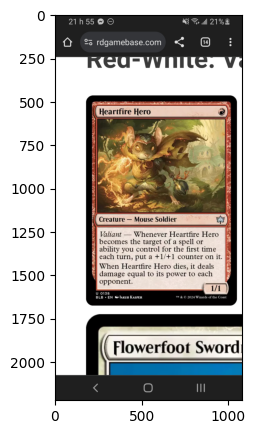

In [4]:

checkpoint = PROJECT_ROOT / "checkpoints" / "sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

image_path = PROJECT_ROOT / "data" / "heartfire_hero.jpg"
image = Image.open(image_path)

image = np.array(image.convert("RGB"))

plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis('on')
plt.show()

In [5]:
input_point = np.array([[375, 500], [500, 1500], [900, 600], [100, 1500]])
input_label = np.array([1, 1, 1, 0])

input_point, input_label = map(
    np.array,
    zip(
        *[
            # ([500, 500], 1),
            ([800, 900], 1),
            # ([600, 1300], 1),
            ([600, 2000], 0),
            # ([500, 300], 0),
        ]
    )
)

In [6]:
# predictor = SAM2ImagePredictor(build_sam2(model_cfg, checkpoint))

# with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
#     predictor.set_image(image)
#     masks, scores, _ = predictor.predict(
#         point_coords=input_point,
#         point_labels=input_label,
#         multimask_output=False,
#     )

# show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label, borders=True)

5
[{'area': 260010,
  'bbox': [0.0, 0.0, 1079.0, 247.0],
  'predicted_iou': 0.9765625,
  'stability_score': 0.9644836783409119},
 {'area': 230111,
  'bbox': [249.0, 1799.0, 830.0, 278.0],
  'predicted_iou': 0.9609375,
  'stability_score': 0.9712610244750977},
 {'area': 570773,
  'bbox': [0.0, 243.0, 1079.0, 1830.0],
  'predicted_iou': 0.9453125,
  'stability_score': 0.9126237034797668},
 {'area': 1038508,
  'bbox': [180.0, 467.0, 863.0, 1208.0],
  'predicted_iou': 0.94140625,
  'stability_score': 0.9197955131530762},
 {'area': 272861,
  'bbox': [237.0, 1145.0, 750.0, 442.0],
  'predicted_iou': 0.91796875,
  'stability_score': 0.9070127606391907}]


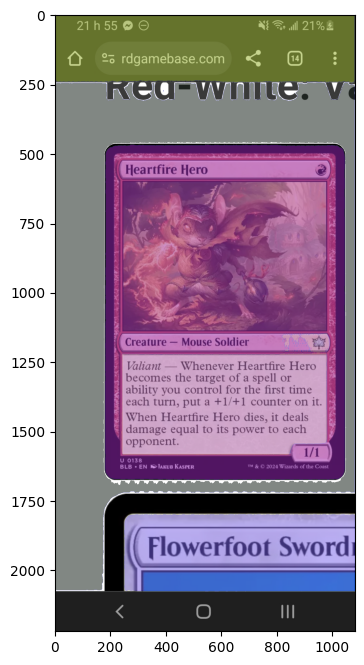

In [56]:
mask_generator = SAM2AutomaticMaskGenerator(
    build_sam2(model_cfg, checkpoint),
    points_per_side=16,
    stability_score_thresh = 0.9,
    stability_score_offset = 0.95,
    min_mask_region_area=5_000,
    # min_mask_region_area=5_000,
    # use_m2m=True,
)

with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    masks = mask_generator.generate(image)

summary_props = ["area", "bbox", "predicted_iou", "stability_score"]
masks_summary = [{prop: mask[prop] for prop in summary_props} for mask in masks]

print(len(masks))
if len(masks) < 8:
    pprint(masks_summary)

plt.figure(figsize=(8, 8))
plt.imshow(image)
show_anns(masks)
plt.axis('on')
plt.show()

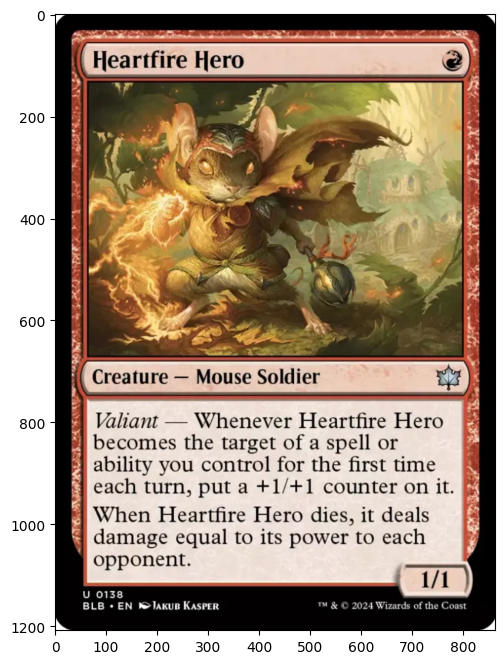

In [62]:
for mask in masks_summary:
    if mask["area"] > 1_000_000:
        x1, y1, w, h = map(int, mask["bbox"])
        plt.figure(figsize=(8, 8))
        plt.imshow(image[y1:y1+h, x1:x1+w])
        plt.axis('on')
        plt.show()